In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.python.ops import rnn, rnn_cell
from tensorflow.python.ops import seq2seq as tfseq2seq

from speech2vec.models import  * 
import numpy as np

from tqdm import tqdm

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

X = mnist.train.images.reshape(55000,28,28)
X_test = mnist.test.images.reshape(10000,28,28)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Learning Parameters

In [14]:
# Model Parameters
nb_epochs = 10000
batch_size = 55

sample, timestep, feature = X.shape

batch_input_shape = ( batch_size, timestep, feature )

hidden_dim = 128

depth = (1,1)

dropout = 0.8

peek = False

latent_dim = 2

In [17]:
X.shape

(55000, 28, 28)

In [15]:
tf.reset_default_graph()

### Define cell

In [16]:
# Define Cell
en_cell = rnn_cell.GRUCell(hidden_dim)

en_cells = [ rnn_cell.MultiRNNCell([en_cell] * depth[0] ) ]

de_cell = rnn_cell.GRUCell(hidden_dim)

de_cells = [ rnn_cell.MultiRNNCell([de_cell] * depth[1] ) ]

### Encoder 

In [17]:
# Input placeholder
x  = tf.placeholder(tf.float32, shape=[None, timestep, feature])
keep_prob = tf.placeholder(tf.float32)

last_output = basic_encoder(en_cells, x, keep_prob)

### Predict Mean & Gaussian of Latent dimension

In [18]:
last_output_drop = tf.nn.dropout( last_output, keep_prob )
# Predict Mean & Variance of Gaussian
W_mu = tf.Variable( xavier_init(hidden_dim, latent_dim) )
b_mu = tf.Variable( tf.zeros([ latent_dim ] ) )

W_logvar = tf.Variable( xavier_init(hidden_dim,latent_dim) )
b_logvar = tf.Variable( tf.zeros([ latent_dim ] ) )

z_mean = tf.matmul(last_output_drop, W_mu) + b_mu
z_logvar = tf.matmul(last_output_drop, W_logvar) + b_logvar

### Sampling ( Reparametrization )

In [19]:
epsilon = tf.random_normal(tf.shape(z_logvar))
z = z_mean + tf.mul( tf.exp(0.5 * z_logvar), epsilon)

### Decoder

In [20]:
z_dropout = tf.nn.dropout(z, keep_prob)

W_z = tf.Variable( xavier_init(latent_dim, hidden_dim) )
b_z = tf.Variable( tf.zeros([ hidden_dim ] ) )

decoder_init = tf.nn.relu( tf.matmul(z_dropout, W_z) + b_z )

In [21]:
   
init_dim = int(decoder_init.get_shape()[1])

decoder_inputs = [ decoder_init ] + [ tf.placeholder(tf.float32, shape=[ batch_size, init_dim ] ) for i in range(timestep-1) ]

def loop(prev, i):
    if peek:
        return prev + z_dropout # Output as input
    else:
        return prev

decoder_outputs, decoder_state = tfseq2seq.rnn_decoder( decoder_inputs, de_cell.zero_state(batch_size,tf.float32), de_cell, loop_function = loop )

W_out = tf.Variable( xavier_init(hidden_dim, feature) )
b_out = tf.Variable( tf.zeros([ feature ] ) )

unpacked_reconstruction = [ tf.matmul( tf.nn.dropout( out, keep_prob ), W_out ) for out in decoder_outputs ]

x_rec = tf.nn.sigmoid( tf.transpose(tf.pack(unpacked_reconstruction), perm=[1, 0, 2]) )

### Cost & Optimizer

In [22]:
learning_rate = 1e-3

latent_loss = -0.5 * tf.reduce_sum(1 + z_logvar - tf.square(z_mean) - tf.exp(z_logvar), 1)
reconstruct_loss = tf.reduce_sum(tf.square(x_rec-x),[1,2])

latent_cost = tf.reduce_mean(latent_loss)
reconstruct_cost = tf.reduce_mean(reconstruct_loss)

cost = latent_cost + reconstruct_cost

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [23]:
saver = tf.train.Saver()

### Training

In [ ]:
min_loss = 10000
with tf.Session() as sess:
    print "Initializing..."
    tf.initialize_all_variables().run()

    for epoch in range(1,nb_epochs+1,1):
        losses = 0.
        latent_loss = 0.
        rec_loss = 0.
        for idx in tqdm(range(0, sample, batch_size)):
            batch_x = X[idx:idx+batch_size]
            loss0, loss1, loss2, _ = sess.run([cost, latent_cost, reconstruct_cost, optimizer], feed_dict={x: batch_x, keep_prob: dropout })

            losses += loss0
            latent_loss += loss1
            rec_loss += loss2
        
        losses /= 1000
        latent_loss /= 1000
        rec_loss /= 1000
        print "Epoch {}, latent loss {}, reconstruct loss {}".format(epoch, latent_loss, rec_loss)
                
        if losses < min_loss:
            min_loss = losses
            save_path = saver.save(sess, "/tmp/mnist_seq2seq_vae.ckpt")
            print("Model saved in file: %s" % save_path)

Initializing...


100%|██████████| 1000/1000 [06:35<00:00,  2.53it/s]


Epoch 1, latent loss 1.30810220444, reconstruct loss 55.2629132385


  0%|          | 0/1000 [00:00<?, ?it/s]

Model saved in file: /tmp/mnist_seq2seq_vae.ckpt


100%|██████████| 1000/1000 [06:35<00:00,  2.52it/s]


Epoch 2, latent loss 2.1346413852, reconstruct loss 48.2032883453


  0%|          | 0/1000 [00:00<?, ?it/s]

Model saved in file: /tmp/mnist_seq2seq_vae.ckpt


 82%|████████▏ | 817/1000 [05:22<01:12,  2.53it/s]

### Visualize latent dim

Illustrating latent dimension
Model restored.


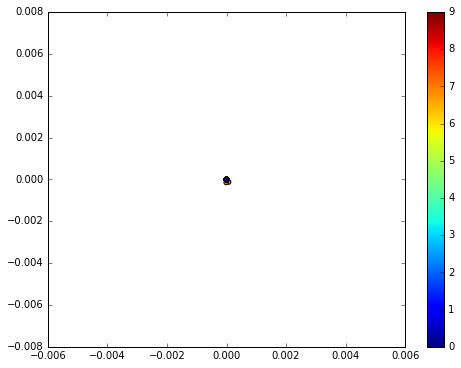

In [24]:
print "Illustrating latent dimension"
with tf.Session() as sess:
    saver.restore(sess, "/tmp/mnist_seq2seq_vae.ckpt")
    print("Model restored.")
    
    examples_to_show = 5000
    x_sample, y_sample = mnist.test.next_batch(examples_to_show)
    x_sample = x_sample.reshape(examples_to_show,timestep,feature)
    z_mu = sess.run( z_logvar, feed_dict={x: x_sample, keep_prob: 1. })
    
    plt.figure(figsize=(8,6))
    plt.scatter( z_mu[:, 0], z_mu[:,1], c=np.argmax(y_sample,1) )
    plt.colorbar()


### Generating MNIST images

Generating Images
Model restored.


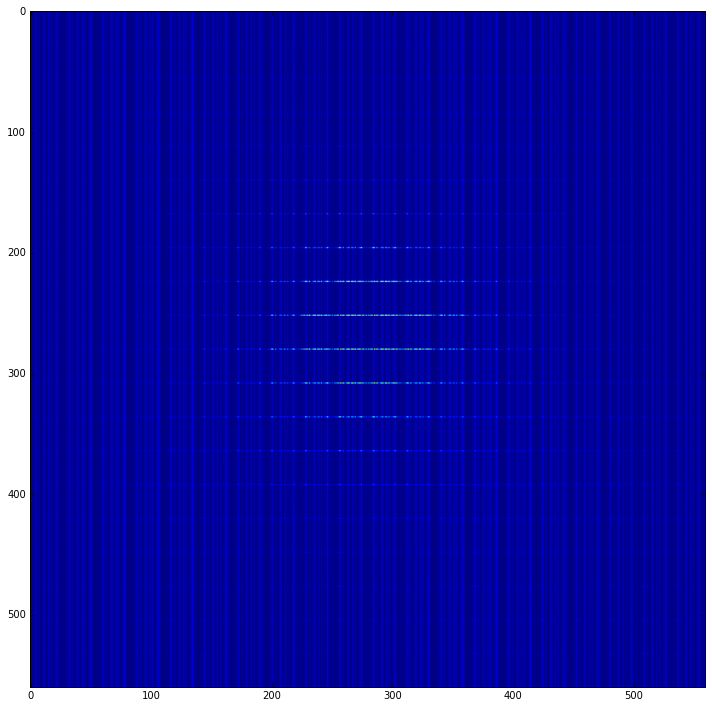

In [25]:
print "Generating Images"
with tf.Session() as sess:
    saver.restore(sess, "/tmp/mnist_seq2seq_vae.ckpt")
    print("Model restored.")
    
    nx = ny = 20
    x_values = np.linspace(-5, 5, nx)
    y_values = np.linspace(-5, 5, ny)

    canvas = np.empty((28*ny, 28*nx))
    for i, xi in enumerate(x_values):
        for j, yi in enumerate(y_values):
            z_mu = np.array([[xi,yi]])
            z_mu = np.tile(z_mu,(55,1))
            
            x_mean = sess.run( x_rec, feed_dict={z: z_mu, keep_prob : 1. })
            canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(10, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper")
plt.tight_layout()